In [1]:
import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt

from imp import load_source

aps = load_source(  'aggregate_player_stats', '../exploration/aggregate_player_stats.py' )
nps = load_source(  'normalize_player_stats', '../normalization/normalize_player_stats.py' )

%matplotlib inline

plt.rcParams['figure.figsize'] = (14,10)
plt.style.use('dark_background')

In [2]:
position = 'QB'
n_weeks  = 4
end_year = 2017

my_df = aps.generate_player_features( end_year, position, n_weeks=n_weeks )

In [3]:
target_variables = [
                    'rush_yds',
                    'rush_tds',
                    'pass_yds',
                    'pass_tds',
                    'turnovers'
                   ]

meta_info     = [
                 'player_id',
                 'team',
                 'week',
                 'year',
                 'team_home_frac_prev_4',
                 'few_reg_weeks'
                ]


player_scales = [
                 'pass_complete_prev_4',
                 'pass_incomplete_prev_4',
                 'pass_air_yds_prev_4',
                 'pass_air_yds_max_prev_4',
                 'pass_yds_prev_4',
                 'pass_att_prev_4'
                ]

player_norms = [
                'pass_int_prev_4',
                'pass_tds_prev_4',
                'rush_yds_prev_4',
                'rush_tds_prev_4',
                'rush_att_prev_4'
                ]

fumb_features    = [
                    'fumb_lost_prev_4', 
                    'fumb_rec_prev_4', 
                    'fumb_forced_prev_4', 
                    'fumb_nforced_prev_4'
                   ]

team_features    = [
                    'team_tds_prev_4',
                    'team_fg_made_prev_4',
                    'team_kickoffs_prev_4',
                    'team_punts_prev_4'
                   ]


opp_features     = [
                    'opp_avg_tds_prev_4', 
                    'opp_avg_fg_made_prev_4',
                    'opp_avg_rush_yds_prev_4', 
                    'opp_avg_pass_yds_prev_4',
                    'opp_avg_def_tkl_loss_prev_4', 
                    'opp_avg_def_sack_prev_4', 
                    'opp_avg_def_pass_def_prev_4'
                   ]

In [4]:
# Make turnovers a feature
temp_df = my_df.copy()

temp_df['turnovers'] = temp_df['pass_int']+temp_df['fumb_lost']
temp_df = temp_df.drop( ['pass_int','fumb_lost'], axis=1 )

# Not calc the frac of home games
temp_df['team_home_frac_prev_4'] = temp_df['team_home_flag_prev_4'] / \
                                  (temp_df['team_home_flag_prev_4'] +
                                   temp_df['team_away_flag_prev_4'] +
                                   0.                               )
temp_df = temp_df.drop( ['team_home_flag_prev_4','team_away_flag_prev_4'], axis=1 )

In [5]:
# Let's start by training
#  on all data pre-2016
# Apparently 2017 preseason data missing from the db
my_train_data = temp_df.loc[ my_df['year']< 2016 ].reset_index().drop( 'index', axis=1 )
my_test_data  = temp_df.loc[ my_df['year']>=2016 ].reset_index().drop( 'index', axis=1 )

In [7]:
# Dictionary to save normalization data in
norm_dict = {}

# Do seperately
df_list = [
            my_train_data,
            my_test_data
          ]

out_df_list = []

# By looping over these,
#  will set data using train data,
#  then apply stuff to test data
# Adds then uses values from the dict
for frame in df_list:
    
    
    # Grab some normalized fumble features
    fumb_junk = nps.fumb_normalization( 
                                        frame, 
                                        fumb_features,
                                        norm_dict
                                      )
    
    # Some normalized team features
    team_junk = nps.team_normalization( 
                                        frame,
                                        team_features,
                                        norm_dict,
                                        'team_fg_miss_prev_4'
                                      )
    
    # Some opposing team features
    opp_junk = nps.opp_normalization( 
                                      frame,
                                      opp_features,
                                      norm_dict
                                    )
    
    # The QB features
    qb_junk = nps.qb_normalization(
                                    frame,
                                    player_norms,
                                    player_scales,
                                    norm_dict
                                  )
    
    # What we will output
    new_frame = frame[meta_info+target_variables]

    # Combine all the stuff into 1 frame
    out_df_list.append(
                        pd.concat( [
                                    new_frame,
                                    qb_junk,
                                    fumb_junk,
                                    team_junk,
                                    opp_junk
                                   ], axis=1).copy()
                      )
    
    
train_norm_data = out_df_list[0].copy()
test_norm_data  = out_df_list[1].copy()
out_df_list     = 0

In [20]:
# 22 features
features = test_norm_data.columns.values[11: ].tolist()+['team_home_frac_prev_4','few_reg_weeks']
targets  = test_norm_data.columns.values[6:11].tolist()

print test_norm_data.columns
print features
print targets

Index([                     u'player_id',                           u'team',
                                 u'week',                           u'year',
                u'team_home_frac_prev_4',                  u'few_reg_weeks',
                             u'rush_yds',                       u'rush_tds',
                             u'pass_yds',                       u'pass_tds',
                            u'turnovers',    u'pass_complete_prev_4_scaled',
        u'pass_incomplete_prev_4_scaled',     u'pass_air_yds_prev_4_scaled',
       u'pass_air_yds_max_prev_4_scaled',         u'pass_yds_prev_4_scaled',
               u'pass_att_prev_4_scaled',           u'pass_int_prev_4_norm',
                 u'pass_tds_prev_4_norm',           u'rush_yds_prev_4_norm',
                 u'rush_tds_prev_4_norm',           u'rush_att_prev_4_norm',
                      u'fumb_pca_0_norm',           u'fumb_pca_1_bc_scaled',
                    u'team_pca_0_scaled',              u'team_pca_1_scaled',

In [22]:
train_x, train_y = train_norm_data[features].values, train_norm_data[targets].values
test_x ,  test_y =  test_norm_data[features].values,  test_norm_data[targets].values

Let's pick some regressors. We will start with a linear regressor, lasso regressor, kneighbors, random forest, and neural network.

We'll do a first round test, select the best, and fine tune from there

In [23]:
from sklearn.linear_model   import LinearRegression
from sklearn.linear_model   import Lasso
from sklearn.neighbors      import KNeighborsRegressor
from sklearn.ensemble       import RandomForestRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.multioutput    import MultiOutputRegressor

In [48]:
def f_rmse(pred, true, cols=['rush_yds', 'rush_tds', 'pass_yds', 'pass_tds', 'turnovers'] ):
    print 'RMSE / Mean'
    for i in range(0,pred.shape[1]):
        print '%12s %8.6f' % ( cols[i], np.sqrt(((pred[:,i] - true[:,i]) ** 2).mean()/true[:,i].mean()) )

def rmse(pred, true, cols=['rush_yds', 'rush_tds', 'pass_yds', 'pass_tds', 'turnovers'] ):
    print 'RMSE'
    for i in range(0,pred.shape[1]):
        print '%12s %8.6f' % ( cols[i], np.sqrt(((pred[:,i] - true[:,i]) ** 2).mean()) )

def r2( pred, true, cols=['rush_yds', 'rush_tds', 'pass_yds', 'pass_tds', 'turnovers'] ):
    print 'R^2'
    for i in range(0,pred.shape[1]):
        y = true[:,i]
        # fit values, and mean
        yhat  = pred[:,i]                # or [p(z) for z in x]
        ybar  = np.sum(y)/len(y)         # or sum(y)/len(y)
        ssreg = np.sum((yhat-ybar)**2)   # or sum([ (yihat - ybar)**2 for yihat in yhat])
        sstot = np.sum((y - ybar)**2)    # or sum([ (yi - ybar)**2 for yi in y])
        print '%12s %8.6f' % ( cols[i], ssreg / sstot )
        
def reg_test( reg, train_x, train_y, test_x, test_y ):
    reg.fit( train_x, train_y )
    print 'Train Data:'
    r2    ( reg.predict( train_x ), train_y )
    rmse  ( reg.predict( train_x ), train_y )
    f_rmse( reg.predict( train_x ), train_y )
    print 'Test Data:'
    r2    ( reg.predict( test_x ), test_y )
    rmse  ( reg.predict( test_x ), test_y )
    f_rmse( reg.predict( test_x ), test_y )

In [49]:
m_lin_reg = MultiOutputRegressor( LinearRegression() )

reg_test( m_lin_reg, train_x, train_y, test_x, test_y )

Train Data:
R^2
    rush_yds 0.292341
    rush_tds 0.129421
    pass_yds 0.228142
    pass_tds 0.204728
   turnovers 0.490472
RMSE
    rush_yds 13.649761
    rush_tds 0.316666
    pass_yds 87.437261
    pass_tds 1.115000
   turnovers 1.037269
RMSE / Mean
    rush_yds 4.226339
    rush_tds 1.003342
    pass_yds 5.844997
    pass_tds 0.940475
   turnovers 1.037943
Test Data:
R^2
    rush_yds 0.281544
    rush_tds 0.126949
    pass_yds 0.243890
    pass_tds 0.235514
   turnovers 0.601460
RMSE
    rush_yds 13.375058
    rush_tds 0.309055
    pass_yds 89.049972
    pass_tds 1.136814
   turnovers 1.003558
RMSE / Mean
    rush_yds 4.215560
    rush_tds 0.935178
    pass_yds 6.009531
    pass_tds 0.991728
   turnovers 1.075737


In [50]:
m_las_reg = MultiOutputRegressor( Lasso(alpha=0.1) )

reg_test( m_las_reg, train_x, train_y, test_x, test_y )

Train Data:
R^2
    rush_yds 0.266485
    rush_tds 0.086142
    pass_yds 0.223650
    pass_tds 0.140899
   turnovers 0.472541
RMSE
    rush_yds 13.664349
    rush_tds 0.324442
    pass_yds 87.445550
    pass_tds 1.138090
   turnovers 1.053303
RMSE / Mean
    rush_yds 4.230856
    rush_tds 1.027979
    pass_yds 5.845551
    pass_tds 0.959950
   turnovers 1.053987
Test Data:
R^2
    rush_yds 0.253503
    rush_tds 0.088098
    pass_yds 0.239737
    pass_tds 0.154577
   turnovers 0.568611
RMSE
    rush_yds 13.361294
    rush_tds 0.317478
    pass_yds 89.011303
    pass_tds 1.131408
   turnovers 1.001765
RMSE / Mean
    rush_yds 4.211222
    rush_tds 0.960666
    pass_yds 6.006921
    pass_tds 0.987013
   turnovers 1.073815


In [53]:
m_knn_reg = MultiOutputRegressor( KNeighborsRegressor(n_neighbors=5) )

reg_test( m_knn_reg, train_x, train_y, test_x, test_y )

Train Data:
R^2
    rush_yds 0.304416
    rush_tds 0.275155
    pass_yds 0.360879
    pass_tds 0.347680
   turnovers 0.577357
RMSE
    rush_yds 12.523065
    rush_tds 0.281762
    pass_yds 76.821720
    pass_tds 0.999922
   turnovers 0.931711
RMSE / Mean
    rush_yds 3.877484
    rush_tds 0.892750
    pass_yds 5.135371
    pass_tds 0.843409
   turnovers 0.932316
Test Data:
R^2
    rush_yds 0.207477
    rush_tds 0.204242
    pass_yds 0.369875
    pass_tds 0.377044
   turnovers 0.718558
RMSE
    rush_yds 15.664416
    rush_tds 0.346312
    pass_yds 94.378042
    pass_tds 1.234404
   turnovers 1.062902
RMSE / Mean
    rush_yds 4.937121
    rush_tds 1.047915
    pass_yds 6.369095
    pass_tds 1.076864
   turnovers 1.139350


In [54]:
m_rfr_reg = MultiOutputRegressor( RandomForestRegressor() )

reg_test( m_rfr_reg, train_x, train_y, test_x, test_y )

Train Data:
R^2
    rush_yds 0.633126
    rush_tds 0.548732
    pass_yds 0.598202
    pass_tds 0.579705
   turnovers 0.750579
RMSE
    rush_yds 6.078632
    rush_tds 0.142746
    pass_yds 38.278503
    pass_tds 0.500752
   turnovers 0.474930
RMSE / Mean
    rush_yds 1.882111
    rush_tds 0.452283
    pass_yds 2.558838
    pass_tds 0.422372
   turnovers 0.475238
Test Data:
R^2
    rush_yds 0.373325
    rush_tds 0.321818
    pass_yds 0.356308
    pass_tds 0.365393
   turnovers 0.761725
RMSE
    rush_yds 13.953703
    rush_tds 0.333663
    pass_yds 91.250800
    pass_tds 1.189136
   turnovers 1.066180
RMSE / Mean
    rush_yds 4.397938
    rush_tds 1.009641
    pass_yds 6.158054
    pass_tds 1.037373
   turnovers 1.142864


In [55]:
m_mlp_reg = MultiOutputRegressor( MLPRegressor() )

reg_test( m_mlp_reg, train_x, train_y, test_x, test_y )

/home/sean/anaconda/lib/python2.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Train Data:
R^2
    rush_yds 0.329583
    rush_tds 0.215967
    pass_yds 0.304003
    pass_tds 0.293802
   turnovers 0.521650
RMSE
    rush_yds 12.889805
    rush_tds 0.293389
    pass_yds 87.927998
    pass_tds 0.989052
   turnovers 0.986554
RMSE / Mean
    rush_yds 3.991036
    rush_tds 0.929588
    pass_yds 5.877802
    pass_tds 0.834240
   turnovers 0.987195
Test Data:
R^2
    rush_yds 0.298279
    rush_tds 0.216371
    pass_yds 0.322303
    pass_tds 0.342163
   turnovers 0.667371
RMSE
    rush_yds 13.747338
    rush_tds 0.320044
    pass_yds 89.112013
    pass_tds 1.183359
   turnovers 1.014069
RMSE / Mean
    rush_yds 4.332896
    rush_tds 0.968430
    pass_yds 6.013718
    pass_tds 1.032333
   turnovers 1.087004


In [59]:
m_mlp_reg = MultiOutputRegressor( MLPRegressor( hidden_layer_sizes=(50,50,50,50,50,)) )

reg_test( m_mlp_reg, train_x, train_y, test_x, test_y )

Train Data:
R^2
    rush_yds 0.772037
    rush_tds 0.796116
    pass_yds 0.277563
    pass_tds 0.657407
   turnovers 0.890640
RMSE
    rush_yds 7.208881
    rush_tds 0.092349
    pass_yds 84.487716
    pass_tds 0.589222
   turnovers 0.449464
RMSE / Mean
    rush_yds 2.232067
    rush_tds 0.292605
    pass_yds 5.647827
    pass_tds 0.496994
   turnovers 0.449756
Test Data:
R^2
    rush_yds 0.707615
    rush_tds 0.351032
    pass_yds 0.332959
    pass_tds 0.762530
   turnovers 1.228277
RMSE
    rush_yds 16.753861
    rush_tds 0.362319
    pass_yds 89.311024
    pass_tds 1.410570
   turnovers 1.400413
RMSE / Mean
    rush_yds 5.280494
    rush_tds 1.096352
    pass_yds 6.027148
    pass_tds 1.230546
   turnovers 1.501135


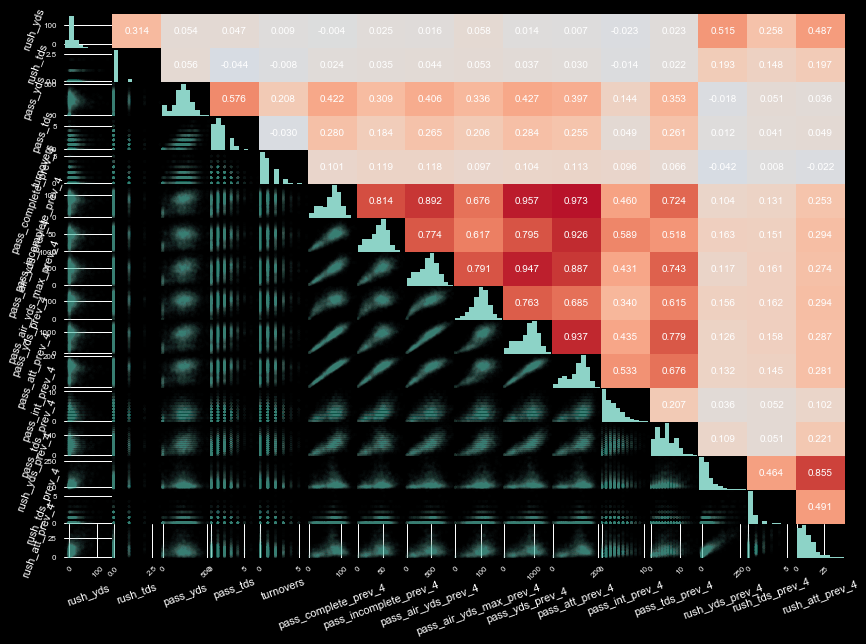

In [62]:
import df_visualizations as dv
reload(dv)

dv.corr_plot( temp_df[target_variables+player_scales+player_norms], alpha=0.01)

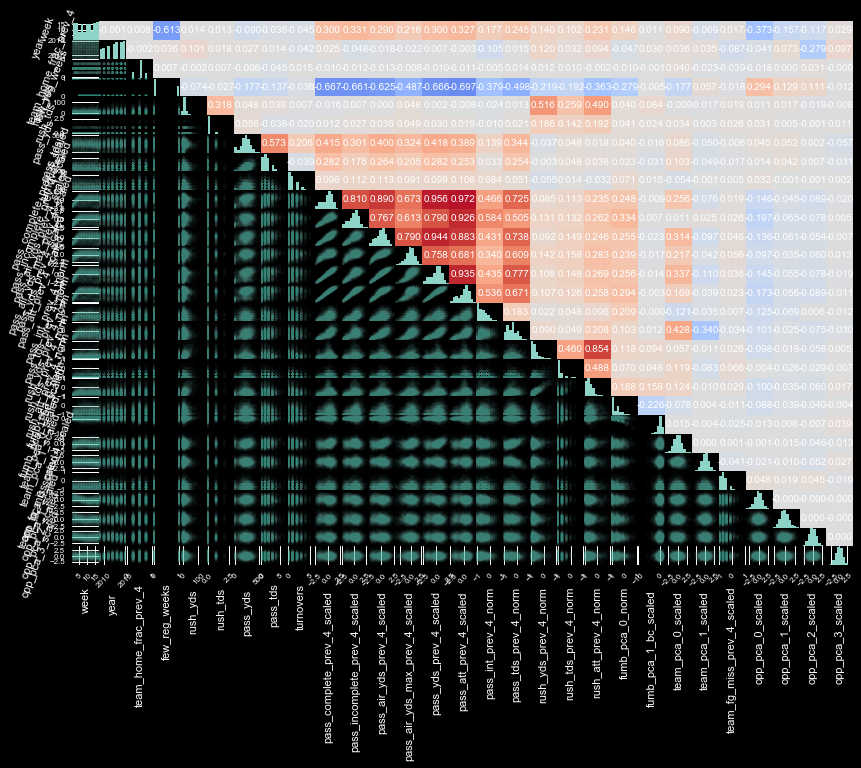

In [66]:
dv.corr_plot( train_norm_data, x_label_rotation=90, alpha=0.01)